## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Opening JSON file 
f = open('./data/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
#Assign new column names
new_col = list(df.columns)
for i in range(len(new_col)):
    new_col[i] = new_col[i].lstrip('_')
    if 'source.' in new_col[i]:
        new_col[i] = new_col[i][7:]
new_col

df.columns = new_col
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace('', np.nan)


In [10]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint_what_happened'])
df = df.reset_index(drop=True)

In [11]:
print(f"Shape after removing null complaints: {df.shape}")

Shape after removing null complaints: (21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    return text.strip()

In [13]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 2]
    return ' '.join(lemmatized)

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_what_happened']].copy()
df_clean['complaint_cleaned'] = df_clean['complaint_what_happened'].apply(clean_text)
df_clean['complaint_lemmatized'] = df_clean['complaint_cleaned'].apply(lemmatize_text)


In [15]:
df_clean

,complaint_what_happened,complaint_cleaned,complaint_lemmatized
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...
...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had cha...,flawless credit yrs chase credit card chase fr...


In [16]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    doc = nlp(text)
    pos_tags = [token.text for token in doc if token.pos_ == 'NOUN' and len(token.text) > 2]
    return ' '.join(pos_tags)

df_clean["complaint_POS_removed"] = df_clean['complaint_lemmatized'].apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [17]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_cleaned,complaint_lemmatized,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application identity consent servi...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...
...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,card provider claim purchase protection purcha...
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer believe chase year trust mob...
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had cha...,flawless credit yrs chase credit card chase fr...,credit yrs chase credit card chase freedom pro...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




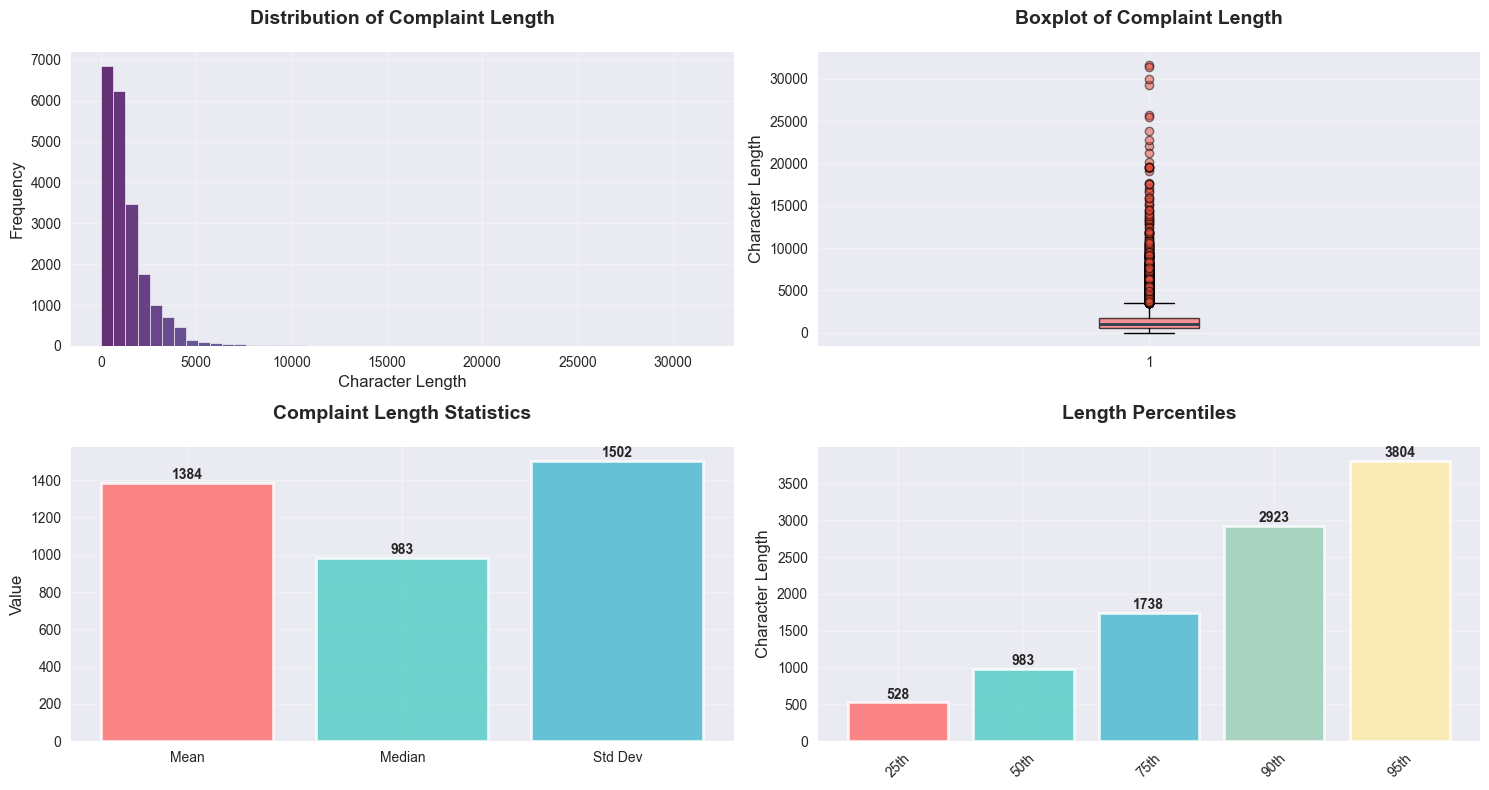

In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length

df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()

# Set style for modern look
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(15, 8))

# Create gradient colors
gradient_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

plt.subplot(2, 2, 1)
# Histogram with gradient color
n, bins, patches = plt.hist(df_clean['complaint_length'], bins=50, alpha=0.8, 
                           color='#4ECDC4', edgecolor='white', linewidth=0.5)
# Apply gradient to histogram bars
for i, p in enumerate(patches):
    p.set_facecolor(plt.cm.viridis(i / len(patches)))
plt.title('Distribution of Complaint Length', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Character Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
# Enhanced boxplot with gradient
box = plt.boxplot(df_clean['complaint_length'], patch_artist=True, 
                  boxprops=dict(facecolor='#FF6B6B', alpha=0.7),
                  medianprops=dict(color='#2C3E50', linewidth=2),
                  flierprops=dict(marker='o', markerfacecolor='#E74C3C', alpha=0.5))
plt.title('Boxplot of Complaint Length', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Character Length', fontsize=12)
plt.grid(True, alpha=0.3)

# Add summary statistics subplot
plt.subplot(2, 2, 3)
stats_data = [df_clean['complaint_length'].mean(), 
              df_clean['complaint_length'].median(),
              df_clean['complaint_length'].std()]
stats_labels = ['Mean', 'Median', 'Std Dev']
bars = plt.bar(stats_labels, stats_data, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8,
               edgecolor='white', linewidth=2)
plt.title('Complaint Length Statistics', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Value', fontsize=12)
for bar, value in zip(bars, stats_data):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{value:.0f}', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3)

# Add distribution by percentiles
plt.subplot(2, 2, 4)
percentiles = [25, 50, 75, 90, 95]
perc_values = [np.percentile(df_clean['complaint_length'], p) for p in percentiles]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars = plt.bar([f'{p}th' for p in percentiles], perc_values, 
               color=colors, alpha=0.8, edgecolor='white', linewidth=2)
plt.title('Length Percentiles', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Character Length', fontsize=12)
plt.xticks(rotation=45)
for bar, value in zip(bars, perc_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{value:.0f}', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

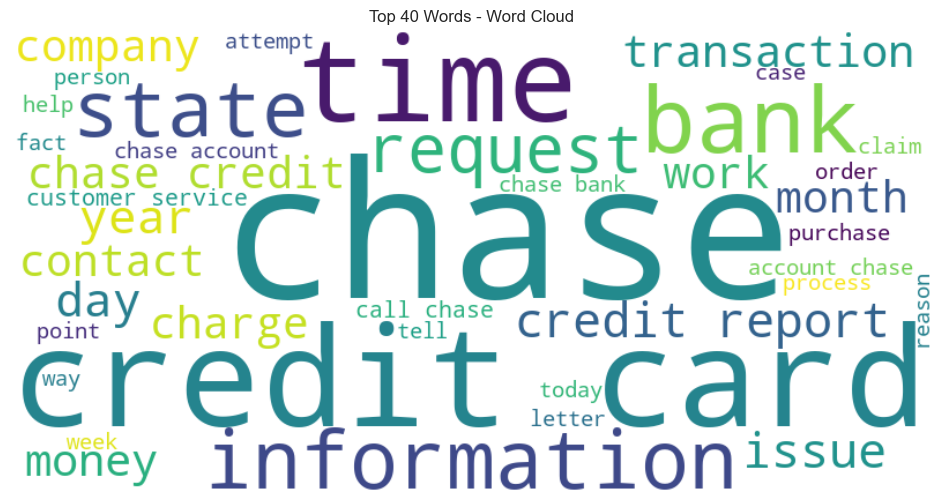

In [19]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
from collections import Counter
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

# Create word cloud
all_words = ' '.join(df_clean['Complaint_clean'].dropna())
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(all_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words - Word Cloud')
plt.show()


In [20]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [21]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_grams(corpus, n=1, top_k=30):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english', max_features=top_k)
    bow = vectorizer.fit_transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

In [22]:
#Print the top 10 words in the unigram frequency
unigrams = get_top_n_grams(df_clean['complaint_POS_removed'].dropna(), n=1, top_k=10)
print("Top 10 Unigrams:")
for word, freq in unigrams:
    print(f"{word}: {freq}")

Top 10 Unigrams:
chase: 57069
account: 40951
credit: 33372
card: 29779
payment: 20892
charge: 16174
time: 15250
bank: 12265
money: 11521
day: 11498


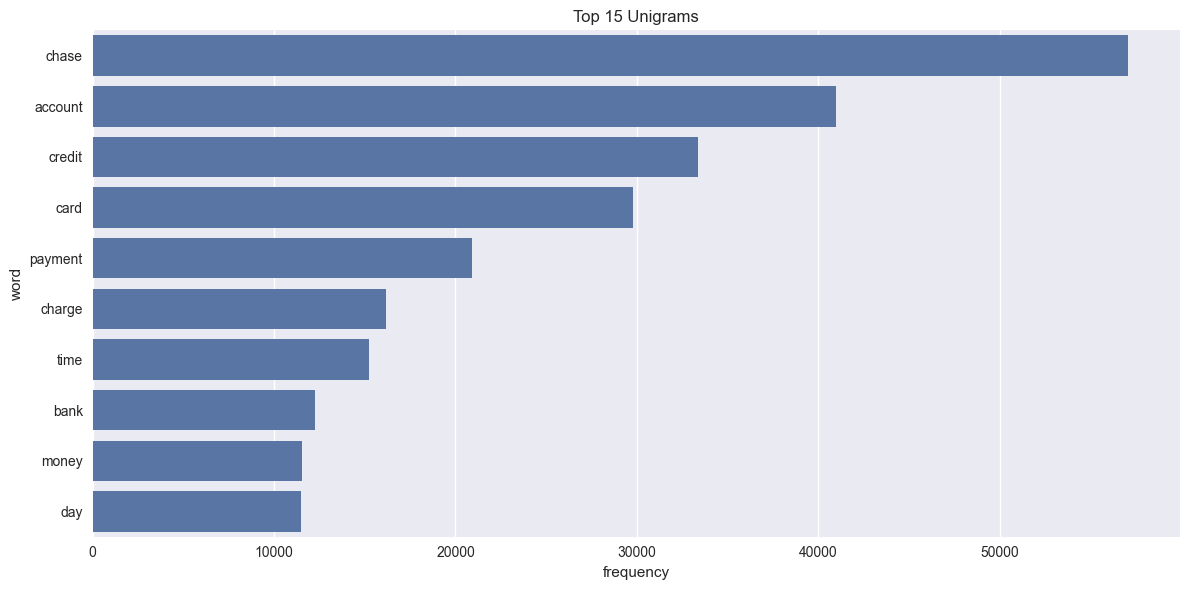

In [23]:
unigram_df = pd.DataFrame(unigrams[:15], columns=['word', 'frequency'])
plt.figure(figsize=(12, 6))
sns.barplot(data=unigram_df, x='frequency', y='word')
plt.title('Top 15 Unigrams')
plt.tight_layout()
plt.show()

In [24]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = get_top_n_grams(df_clean['Complaint_clean'].dropna(), n=2, top_k=30)
print("\nTop 30 Bigrams:")
for word, freq in bigrams[:30]:
    print(f"{word}: {freq}")


Top 30 Bigrams:
credit card: 12653
credit report: 3823
chase credit: 3107
customer service: 2940
account chase: 2856
chase bank: 2586
chase account: 2302
contact chase: 1973
debit card: 1898
account account: 1817
credit score: 1704
card chase: 1684
check account: 1607
card account: 1566
chase card: 1404
payment payment: 1320
money account: 1272
letter chase: 1256
account credit: 1255
chase customer: 1252
phone number: 1243
credit account: 1153
payment chase: 1149
charge account: 1117
card company: 1105
chase chase: 1099
account number: 1049
report credit: 1045
charge chase: 1031
dispute charge: 1029


In [25]:
#Print the top 10 words in the bigram frequency
bigrams = get_top_n_grams(df_clean['Complaint_clean'].dropna(), n=2, top_k=10)
print("\nTop 10 Bigrams:")
for word, freq in bigrams:
    print(f"{word}: {freq}")


Top 10 Bigrams:
credit card: 12653
credit report: 3823
chase credit: 3107
customer service: 2940
account chase: 2856
chase bank: 2586
chase account: 2302
contact chase: 1973
debit card: 1898
account account: 1817


In [26]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = get_top_n_grams(df_clean['Complaint_clean'].dropna(), n=3, top_k=30)
print("\nTop 30 Trigrams:")
for word, freq in trigrams[:30]:
    print(f"{word}: {freq}")


Top 30 Trigrams:
chase credit card: 2199
credit card account: 1029
credit card company: 982
credit card chase: 850
chase customer service: 615
charge credit card: 491
inquiry credit report: 482
credit card credit: 451
credit reporting agency: 378
file police report: 374
account credit card: 349
credit card charge: 347
card credit card: 339
credit reporting act: 325
credit report credit: 319
customer service representative: 303
credit card payment: 299
chase check account: 294
account credit report: 248
chase auto finance: 243
credit card balance: 238
credit report chase: 232
freedom credit card: 227
credit card service: 225
account chase account: 220
account chase bank: 218
victim identity theft: 216
credit card statement: 214
chase card service: 212
credit card card: 210


In [27]:
#Print the top 10 words in the trigram frequency
trigrams = get_top_n_grams(df_clean['Complaint_clean'].dropna(), n=3, top_k=10)
print("\nTop 10 Trigrams:")
for word, freq in trigrams:
    print(f"{word}: {freq}")


Top 10 Trigrams:
chase credit card: 2199
credit card account: 1029
credit card company: 982
credit card chase: 850
chase customer service: 615
charge credit card: 491
inquiry credit report: 482
credit card credit: 451
credit reporting agency: 378
file police report: 374


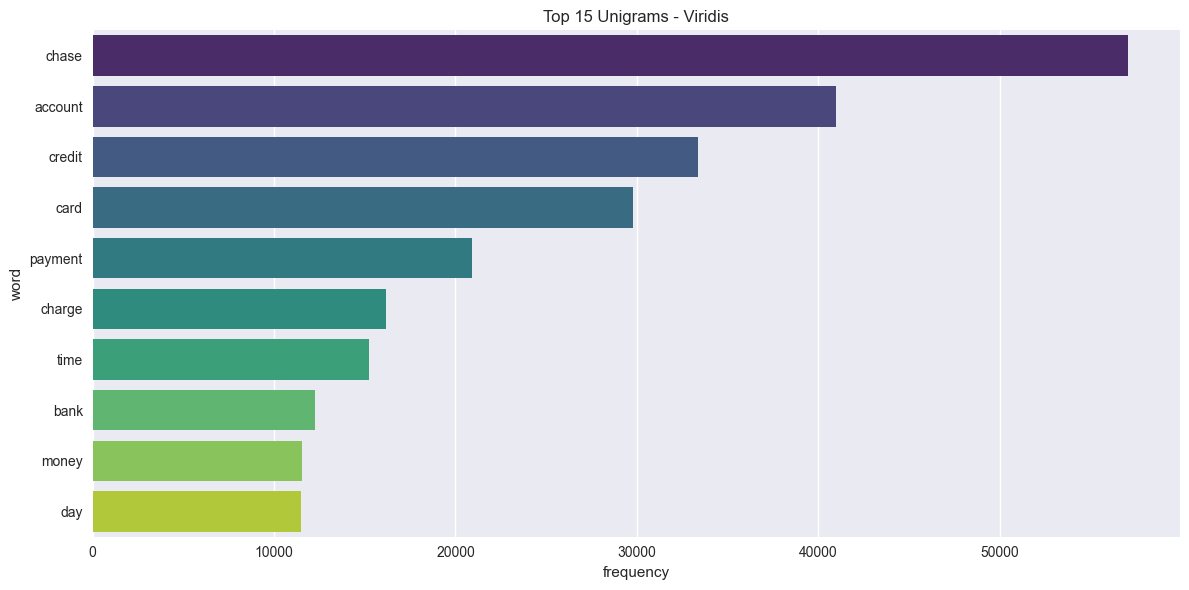

In [28]:
# Visualize trigrams
trigram_df = pd.DataFrame(trigrams[:15], columns=['word', 'frequency'])
plt.figure(figsize=(12, 6))
sns.barplot(data=unigram_df, x='frequency', y='word', hue='word', palette='viridis', legend=False)
plt.title('Top 15 Unigrams - Viridis')
plt.tight_layout()
plt.show()


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [29]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [30]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_cleaned,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,486,morning help chase debt verification statement...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,355,agent anniversary date change agent informatio...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application identity consent servi...,224,card report application identity consent servi...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,1502,book offer ticket reward card information minu...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...,477,son deposit chase account fund account pay mon...
...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,679,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,card provider claim purchase protection purcha...,2114,card provider claim purchase protection purcha...
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer believe chase year trust mob...,2319,pay risk consumer believe chase year trust mob...
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had cha...,flawless credit yrs chase credit card chase fr...,credit yrs chase credit card chase freedom pro...,2171,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [31]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, 
                       min_df=2, 
                       stop_words='english', 
                       lowercase=True, 
                       token_pattern=r'[a-zA-Z-][a-zA-Z-]{2,}')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [32]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'].dropna())
print(f"Shape of DTM: {dtm.shape}")

Shape of DTM: (21072, 6506)


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [33]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [34]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)#write your code here

In [35]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6506

In [36]:
#Print the Top15 words for each of the topics
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topic_dict

feature_names = tfidf.get_feature_names_out()
topic_dict = display_topics(nmf_model, feature_names, 15)

for topic_idx, words in topic_dict.items():
    print(f'Topic {topic_idx}: {", ".join(words)}')

Topic 0: account, check, money, chase, deposit, bank, fund, day, branch, transfer, number, transaction, claim, business, customer
Topic 1: credit, card, report, inquiry, chase, account, score, company, information, debt, limit, application, letter, year, reporting
Topic 2: payment, balance, month, pay, statement, fee, day, time, auto, chase, credit, date, mortgage, error, year
Topic 3: charge, card, fee, dispute, chase, transaction, purchase, merchant, claim, service, balance, fraud, refund, statement, time
Topic 4: loan, mortgage, chase, modification, home, property, year, letter, document, rate, request, time, foreclosure, sale, information


In [37]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

doc_topic = nmf_model.transform(dtm)
dominant_topic = np.argmax(doc_topic, axis=1)

In [38]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = dominant_topic #write your code to assign topics to each rows.

In [39]:
df_clean.head()

,complaint_what_happened,complaint_cleaned,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,486,morning help chase debt verification statement...,4
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,355,agent anniversary date change agent informatio...,0
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application identity consent servi...,224,card report application identity consent servi...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,1502,book offer ticket reward card information minu...,1
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...,477,son deposit chase account fund account pay mon...,0


In [40]:
#Print the first 5 Complaint for each of the Topics (but don't limit the dataset)
# df_clean=df_clean.groupby('Topic').head(5)  # COMMENTED OUT - This was limiting dataset to only 25 rows!
print("Sample complaints for each topic:")
print(df_clean.groupby('Topic').head(2).sort_values('Topic')[['complaint_what_happened', 'Topic']])
print(f"\nTotal complaints in dataset: {len(df_clean)}")
print(f"Topic distribution: {df_clean['Topic'].value_counts().sort_index()}")

Sample complaints for each topic:
                              complaint_what_happened  Topic
1   I upgraded my XXXX XXXX card in XX/XX/2018 and...      0
4   my grand son give me check for {$1600.00} i de...      0
2   Chase Card was reported on XX/XX/2019. However...      1
3   On XX/XX/2018, while trying to book a XXXX  XX...      1
24  I made a purchase of {$260.00} on XX/XX/XXXX. ...      2
33  I recently called to ask Chase bank why they r...      2
8   On XXXX XX/XX/2019, I made a {$300.00} payment...      3
13  To whom it may concern, Chase bank charged wro...      3
0   Good morning my name is XXXX XXXX and I apprec...      4
7   During the summer months, I experience a decli...      4

Total complaints in dataset: 21072
Topic distribution: Topic
0    5065
1    4964
2    2265
3    4583
4    4195
Name: count, dtype: int64


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [41]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card', 
    2: 'Theft/Dispute Reporting',
    3: 'Mortgage/Loan',
    4: 'Others'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [42]:
df_clean

,complaint_what_happened,complaint_cleaned,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,486,morning help chase debt verification statement...,Others
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,355,agent anniversary date change agent informatio...,Bank Account services
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application identity consent servi...,224,card report application identity consent servi...,Credit card or prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,1502,book offer ticket reward card information minu...,Credit card or prepaid card
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...,477,son deposit chase account fund account pay mon...,Bank Account services
...,...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,679,chase card customer decade solicitation credit...,Credit card or prepaid card
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,card provider claim purchase protection purcha...,2114,card provider claim purchase protection purcha...,Mortgage/Loan
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer believe chase year trust mob...,2319,pay risk consumer believe chase year trust mob...,Mortgage/Loan
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had cha...,flawless credit yrs chase credit card chase fr...,credit yrs chase credit card chase freedom pro...,2171,credit yrs chase credit card chase freedom pro...,Theft/Dispute Reporting


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [43]:
#Create the dictionary again of Topic names and Topics

# Create the dictionary again of Topic names and Topics
Topic_names_reverse = {
    'Bank Account services': 0,
    'Credit card or prepaid card': 1, 
    'Theft/Dispute Reporting': 2,
    'Mortgage/Loan': 3,
    'Others': 4
}

# Replace Topic Names with Topic Numbers (use Topic_names_reverse, not Topic_names)
df_clean['Topic'] = df_clean['Topic'].map(Topic_names_reverse)

df_clean

# Let's also check for any mapping issues
print("Checking Topic mapping:")
print("Unique values before mapping:")
print(df_clean['Topic'].value_counts())

print("\nAny NaN values?")
print(df_clean['Topic'].isna().sum())

# If there are still NaN values, let's debug
if df_clean['Topic'].isna().sum() > 0:
    print("\nDebugging NaN values...")
    # Check what the original topic names were before mapping
    df_temp = df_clean.copy()
    
    # Reset to the original topic assignment from NMF
    doc_topic = nmf_model.transform(dtm)
    dominant_topic = np.argmax(doc_topic, axis=1)
    
    # Create original Topic_names mapping
    Topic_names = {
        0: 'Bank Account services',
        1: 'Credit card or prepaid card', 
        2: 'Theft/Dispute Reporting',
        3: 'Mortgage/Loan',
        4: 'Others'
    }
    
    # Apply correct mapping sequence
    df_clean['Topic'] = dominant_topic  # Start with numbers
    print(f"After assigning dominant topics: {df_clean['Topic'].value_counts()}")
    
    df_clean['Topic'] = df_clean['Topic'].map(Topic_names)  # Convert to names
    print(f"After mapping to names: {df_clean['Topic'].value_counts()}")
    
    df_clean['Topic'] = df_clean['Topic'].map(Topic_names_reverse)  # Convert back to numbers
    print(f"After mapping back to numbers: {df_clean['Topic'].value_counts()}")

print(f"\nFinal Topic distribution:")
print(df_clean['Topic'].value_counts())

Checking Topic mapping:
Unique values before mapping:
Topic
0    5065
1    4964
3    4583
4    4195
2    2265
Name: count, dtype: int64

Any NaN values?
0

Final Topic distribution:
Topic
0    5065
1    4964
3    4583
4    4195
2    2265
Name: count, dtype: int64


In [44]:
df_clean

,complaint_what_happened,complaint_cleaned,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,486,morning help chase debt verification statement...,4
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,355,agent anniversary date change agent informatio...,0
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application identity consent servi...,224,card report application identity consent servi...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,1502,book offer ticket reward card information minu...,1
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...,477,son deposit chase account fund account pay mon...,0
...,...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,679,chase card customer decade solicitation credit...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,card provider claim purchase protection purcha...,2114,card provider claim purchase protection purcha...,3
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer believe chase year trust mob...,2319,pay risk consumer believe chase year trust mob...,3
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had cha...,flawless credit yrs chase credit card chase fr...,credit yrs chase credit card chase freedom pro...,2171,credit yrs chase credit card chase freedom pro...,2


In [45]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']].copy()

In [46]:
training_data

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I apprec...,4
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,0
2,Chase Card was reported on XX/XX/2019. However...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",1
4,my grand son give me check for {$1600.00} i de...,0
...,...,...
21067,After being a Chase Card customer for well ove...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",3
21069,I am not familiar with XXXX pay and did not un...,3
21070,I have had flawless credit for 30 yrs. I've ha...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [47]:

#Write your code to get the Vector count
count_vect = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_tfidf = tfidf_transformer.fit_transform(training_data['complaint_what_happened'])

In [48]:
# Split the data
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, training_data['Topic'], 
    test_size=0.2, random_state=42, stratify=training_data['Topic']
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (16857, 15947)
Test set shape: (4215, 15947)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [49]:
# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [50]:
# function to evaluate the model and display the results
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    print('Accuracy: ', round(accuracy_score(y_test,y_pred),2))
    print('Precision: ', round(precision_score(y_test,y_pred,average='weighted'),2))
    print('Recall: ', round(recall_score(y_test,y_pred,average='weighted'),2))
    print('F1 Score: ', round(f1_score(y_test,y_pred,average='weighted'),2))
    print('ROC AUC Score: ', round(roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr'),2))
    print('Classification Report: ', classification_report(y_test,y_pred))

In [51]:
# function to grid search the best parameters for the model
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid={},cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1)
    grid.fit(X_train,y_train)
    return grid.best_estimator_

In [52]:
# Step 1: Prepare training data using original text
print("Preparing training data using original text...")

# Use the Topic assignments from NMF but original text for features
training_data = df_clean[['complaint_what_happened', 'Topic']].copy()

print(f"Training data shape: {training_data.shape}")
print(f"Topic distribution: {training_data['Topic'].value_counts().sort_index()}")

# Step 2: Use CountVectorizer + TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
print("Creating count vectors from original text...")
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

print("Transforming to TF-IDF...")
tfidf_transformer = TfidfTransformer()
X_train_tf = tfidf_transformer.fit_transform(X_train_counts)

print(f"Feature matrix shape: {X_train_tf.shape}")

# Step 3: Train-test split with stratification
train_X, test_X, train_y, test_y = train_test_split(
    X_train_tf, training_data['Topic'], 
    test_size=0.2, random_state=40, stratify=training_data['Topic']
)

print(f"Training set shape: {train_X.shape}")
print(f"Test set shape: {test_X.shape}")

# Check class distribution
print("\nClass distribution:")
print(train_y.value_counts().sort_index())

# Step 4: Model building with GridSearchCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def run_model_with_gridsearch(model, param_grid):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='f1_weighted', verbose=1, n_jobs=-1)
    grid.fit(train_X, train_y)
    return grid.best_estimator_

# Dictionary to store results
model_results = {}

Preparing training data using original text...
Training data shape: (21072, 2)
Topic distribution: Topic
0    5065
1    4964
2    2265
3    4583
4    4195
Name: count, dtype: int64
Creating count vectors from original text...
Transforming to TF-IDF...
Feature matrix shape: (21072, 29725)
Training set shape: (16857, 29725)
Test set shape: (4215, 29725)

Class distribution:
Topic
0    4052
1    3971
2    1812
3    3666
4    3356
Name: count, dtype: int64


In [53]:
# 1. Logistic Regression with GridSearch
print("\n" + "="*60)
print("Training Logistic Regression with GridSearchCV...")
print("="*60)

lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000],
    'class_weight': [None, 'balanced']
}

lr_model = run_model_with_gridsearch(LogisticRegression(random_state=42), lr_params)
print(f"Best parameters: {lr_model.get_params()}")

# Predictions
lr_train_pred = lr_model.predict(train_X)
lr_train_proba = lr_model.predict_proba(train_X)
lr_test_pred = lr_model.predict(test_X)
lr_test_proba = lr_model.predict_proba(test_X)

print("\nLogistic Regression Results:")
eval_model(train_y, lr_train_pred, lr_train_proba, type='Training')
eval_model(test_y, lr_test_pred, lr_test_proba, type='Test')

model_results['Logistic Regression'] = {
    'model': lr_model,
    'train_accuracy': accuracy_score(train_y, lr_train_pred),
    'test_accuracy': accuracy_score(test_y, lr_test_pred),
    'test_predictions': lr_test_pred,
    'test_probabilities': lr_test_proba
}


Training Logistic Regression with GridSearchCV...
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Best parameters: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Logistic Regression Results:
Training results
Accuracy:  0.94
Precision:  0.94
Recall:  0.94
F1 Score:  0.94
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       0.94      0.95      0.94      4052
           1       0.95      0.95      0.95      3971
           2       0.95      0.93      0.94      1812
           3       0.94      0.94      0.94      3666
           4       0.94      0.95      0.94      3356

    accuracy                           0.94     16857
   macro avg       0.94      0.94      0.94     16857
weighted avg       0.94      0.94      0.94     16857

Test results
Accuracy:  0.92
Precision:  0.92
Recall:  0.92
F

In [54]:
# 2. Random Forest with GridSearch
print("\n" + "="*60)
print("Training Random Forest with GridSearchCV...")
print("="*60)

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

rf_model = run_model_with_gridsearch(RandomForestClassifier(random_state=42), rf_params)
print(f"Best parameters: {rf_model.get_params()}")

# Predictions
rf_train_pred = rf_model.predict(train_X)
rf_train_proba = rf_model.predict_proba(train_X)
rf_test_pred = rf_model.predict(test_X)
rf_test_proba = rf_model.predict_proba(test_X)

print("\nRandom Forest Results:")
eval_model(train_y, rf_train_pred, rf_train_proba, type='Training')
eval_model(test_y, rf_test_pred, rf_test_proba, type='Test')

model_results['Random Forest'] = {
    'model': rf_model,
    'train_accuracy': accuracy_score(train_y, rf_train_pred),
    'test_accuracy': accuracy_score(test_y, rf_test_pred),
    'test_predictions': rf_test_pred,
    'test_probabilities': rf_test_proba
}


Training Random Forest with GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Random Forest Results:
Training results
Accuracy:  0.99
Precision:  0.99
Recall:  0.99
F1 Score:  0.99
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       0.99      0.99      0.99      4052
           1       0.98      1.00      0.99      3971
           2       1.00      1.00      1.00      1812
           3       1.00      0.99      0.99      3666
           4       0.99      0.99    

In [55]:
# 3. Decision Tree with GridSearch
print("\n" + "="*60)
print("Training Decision Tree with GridSearchCV...")
print("="*60)

dt_params = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

dt_model = run_model_with_gridsearch(DecisionTreeClassifier(random_state=42), dt_params)
print(f"Best parameters: {dt_model.get_params()}")

# Predictions
dt_train_pred = dt_model.predict(train_X)
dt_train_proba = dt_model.predict_proba(train_X)
dt_test_pred = dt_model.predict(test_X)
dt_test_proba = dt_model.predict_proba(test_X)

print("\nDecision Tree Results:")
eval_model(train_y, dt_train_pred, dt_train_proba, type='Training')
eval_model(test_y, dt_test_pred, dt_test_proba, type='Test')

model_results['Decision Tree'] = {
    'model': dt_model,
    'train_accuracy': accuracy_score(train_y, dt_train_pred),
    'test_accuracy': accuracy_score(test_y, dt_test_pred),
    'test_predictions': dt_test_pred,
    'test_probabilities': dt_test_proba
}


Training Decision Tree with GridSearchCV...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}

Decision Tree Results:
Training results
Accuracy:  0.89
Precision:  0.89
Recall:  0.89
F1 Score:  0.89
ROC AUC Score:  0.98
Classification Report:                precision    recall  f1-score   support

           0       0.90      0.87      0.89      4052
           1       0.91      0.90      0.90      3971
           2       0.89      0.96      0.92      1812
           3       0.93      0.86      0.89      3666
           4       0.83      0.90      0.86      3356

    accuracy                           0.89     16857
   macro avg       0.89      0.90      0.

In [56]:
# 4. Multinomial Naive Bayes
print("\n" + "="*60)
print("Training Multinomial Naive Bayes...")
print("="*60)

nb_params = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

nb_model = run_model_with_gridsearch(MultinomialNB(), nb_params)
print(f"Best parameters: {nb_model.get_params()}")

# Predictions
nb_train_pred = nb_model.predict(train_X)
nb_train_proba = nb_model.predict_proba(train_X)
nb_test_pred = nb_model.predict(test_X)
nb_test_proba = nb_model.predict_proba(test_X)

print("\nNaive Bayes Results:")
eval_model(train_y, nb_train_pred, nb_train_proba, type='Training')
eval_model(test_y, nb_test_pred, nb_test_proba, type='Test')

model_results['Naive Bayes'] = {
    'model': nb_model,
    'train_accuracy': accuracy_score(train_y, nb_train_pred),
    'test_accuracy': accuracy_score(test_y, nb_test_pred),
    'test_predictions': nb_test_pred,
    'test_probabilities': nb_test_proba
}


Training Multinomial Naive Bayes...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': False, 'force_alpha': True}

Naive Bayes Results:
Training results
Accuracy:  0.86
Precision:  0.86
Recall:  0.86
F1 Score:  0.86
ROC AUC Score:  0.98
Classification Report:                precision    recall  f1-score   support

           0       0.85      0.91      0.88      4052
           1       0.86      0.84      0.85      3971
           2       0.82      0.78      0.80      1812
           3       0.86      0.88      0.87      3666
           4       0.91      0.86      0.89      3356

    accuracy                           0.86     16857
   macro avg       0.86      0.85      0.86     16857
weighted avg       0.86      0.86      0.86     16857

Test results
Accuracy:  0.77
Precision:  0.77
Recall:  0.77
F1 Score:  0.77
ROC AUC Score:  0.95
Classification Report:                precision    recall  f1-score   suppor

In [57]:
# Results comparison
print("\n" + "="*80)
print("FINAL RESULTS COMPARISON")
print("="*80)

results_df = pd.DataFrame([
    {
        'Model': name, 
        'Train_Accuracy': results['train_accuracy'],
        'Test_Accuracy': results['test_accuracy']
    } 
    for name, results in model_results.items()
])

results_df = results_df.sort_values(by='Test_Accuracy', ascending=False)
print(results_df)



FINAL RESULTS COMPARISON
                 Model  Train_Accuracy  Test_Accuracy
0  Logistic Regression        0.942932       0.923606
1        Random Forest        0.991873       0.835587
2        Decision Tree        0.891499       0.780071
3          Naive Bayes        0.863617       0.771056


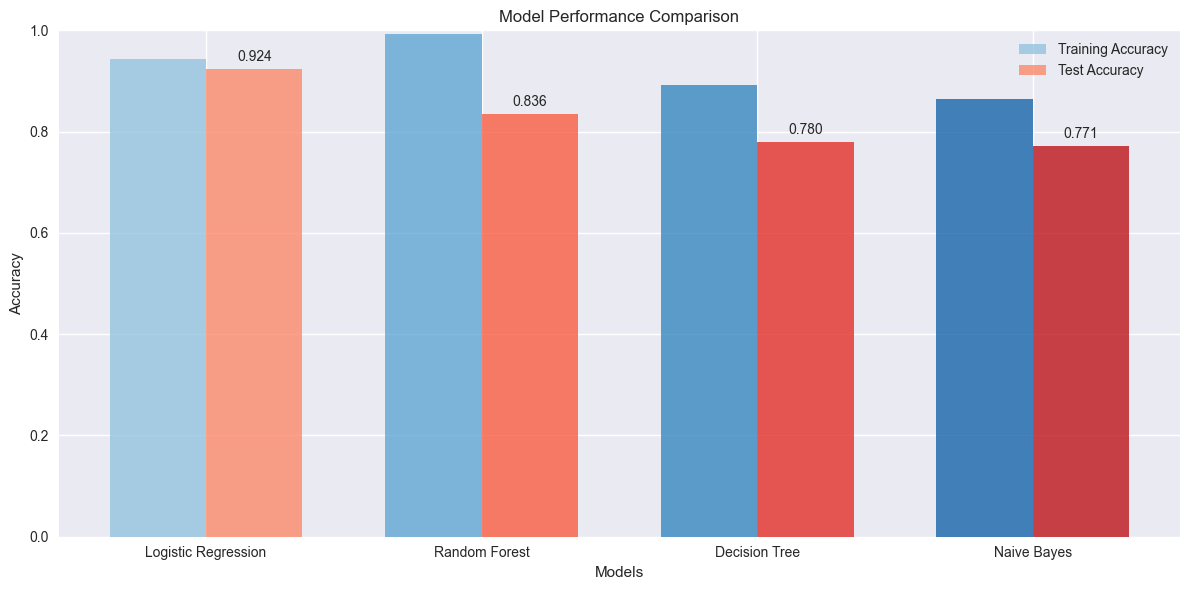

In [58]:
# Visualization

plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.35

# Create custom colormaps
train_colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(results_df)))
test_colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(results_df)))

bars1 = plt.bar(x - width/2, results_df['Train_Accuracy'], width, 
                label='Training Accuracy', color=train_colors, alpha=0.8)
bars2 = plt.bar(x + width/2, results_df['Test_Accuracy'], width, 
                label='Test Accuracy', color=test_colors, alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, results_df['Model'])
plt.legend()
plt.ylim(0, 1)

for i, v in enumerate(results_df['Test_Accuracy']):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



BEST MODEL: Logistic Regression
Test Accuracy: 0.9236


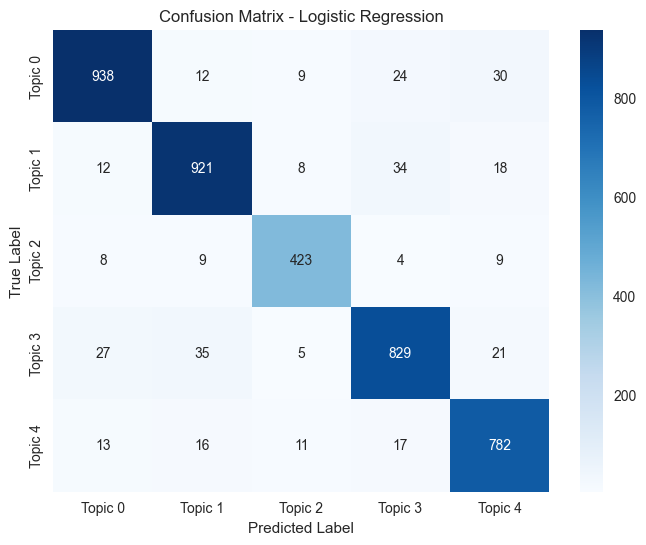

In [59]:
# Best model details
best_model_name = results_df.iloc[0]['Model']
best_model_info = model_results[best_model_name]

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test Accuracy: {best_model_info['test_accuracy']:.4f}")
print(f"{'='*80}")

# Confusion Matrix for best model
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, best_model_info['test_predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Topic {i}' for i in range(5)],
            yticklabels=[f'Topic {i}' for i in range(5)])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [60]:
def predict_lr(text):
    Topic_names_corrected = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card', 
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan' 
}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr_model.predict(X_new_tfidf)
    return Topic_names_corrected[predicted[0]]

# Applying the best model on the Custom Text - Updated test cases
df_complaints = pd.DataFrame({'complaints': [
    "I can not get from chase who services my mortgage, who owns it and who has original loan docs",  # Should be Mortgage/Loan
    "I want to open a salary account at your downtown branch. Please provide me the procedure.",  # Should be Bank Account services
    "Yesterday, I received a fraudulent email regarding renewal of my services.",  # Should be Theft/Dispute Reporting
    "What is the procedure to know my CIBIL score?",  # Should be Credit card/prepaid card
    "I see some payment/billing issues, dont know what to do", # Should be Others
    "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",  # Should be Credit card or prepaid card
    "I need to know the number of bank branches and their locations in the city of Dubai",  # Should be Bank Account services or Others
    "I applied for a home loan, and the process has been dragging for over a month. I've submitted all the necessary documents multiple times, but every time I call, I get inconsistent information about what's missing. The communication is frustrating, and I'm at risk of losing the house I'm trying to buy.",  # Should be Mortgage/Loan
    "I made a wire transfer to an overseas account, and it's been over a week without the funds reaching the recipient. When I called the bank to inquire, they couldn't give me a clear answer about where the money is or when it will be delivered."  # Should be Bank Account services
]})
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
with pd.option_context('display.max_colwidth', None):
    display(df_complaints.head(7))

,complaints,tag
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs",Mortgage/Loan
1,I want to open a salary account at your downtown branch. Please provide me the procedure.,Bank Account services
2,"Yesterday, I received a fraudulent email regarding renewal of my services.",Theft/Dispute Reporting
3,What is the procedure to know my CIBIL score?,Mortgage/Loan
4,"I see some payment/billing issues, dont know what to do",Others
5,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Credit card or prepaid card
6,I need to know the number of bank branches and their locations in the city of Dubai,Bank Account services


### Logistic Regression has highest accuracy of 0.93, Hence is a good fit for this particular case study.